TODOs:

- [ ] add more data sources for calculating travel times

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

#!pip install rapidfuzz
from rapidfuzz import process, fuzz

# Q3: How can we estimate the typical travel time between the city’s central rail station and its nearest major airport, and how should this time be incorporated into the total air travel duration?

## Load and Analyse Data from XLSX Files

In [2]:
# Path to the data directory
data_path = "../Data"

# List all xlsx files in the data directorya
xlsx_files = [f for f in os.listdir(data_path) if f.endswith(".xlsx")]

In [3]:
# Dictionary to hold dataframes
dataframes = {}

for file in xlsx_files:
    file_path = os.path.join(data_path, file)
    if file == "Airports_Rail_Access.xlsx":
        df = pd.read_excel(file_path, header=1, sheet_name=0)  # multi-index columns
    else:
        df = pd.read_excel(file_path, sheet_name=0)  # only 1 sheet per file
    dataframes[file] = df
    print(f"Loaded: {file} — Shape: {df.shape} - Missing values: {df.isnull().sum().sum()}")

dataframes_list = list(dataframes.items())

Loaded: Airports_Rail_Access.xlsx — Shape: (318, 25) - Missing values: 309
Loaded: Candidate_Rail_Routes.xlsx — Shape: (8612, 11) - Missing values: 3172
Loaded: Alternative_Rail_Routes_Unidirectional.xlsx — Shape: (7425, 30) - Missing values: 27010
Loaded: Alternative_Rail_Routes_Bidirectional.xlsx — Shape: (3814, 16) - Missing values: 5148
Loaded: Airports_Indicators.xlsx — Shape: (58, 10) - Missing values: 0


### Analyse Airports_Rail_Access.xlsx

In [4]:
# Airports_Rail_Access.xlsx
filename_ARA, df_ARA = dataframes_list[0]

# Important columns
df_ARA_clean = df_ARA[["Airport", "IATA Code", "Train connection to City Station"]].copy()

# Rename columns for easier access
df_ARA_clean = df_ARA_clean.rename(columns={
    "Airport": "airport",
    "IATA Code": "iata_code",
    "Train connection to City Station": "connection_text"
})

# Extract city airport time in minutes using regex
df_ARA_clean["city_airport_time_min"] = df_ARA_clean["connection_text"].str.extract(r"(\d+)\s*min").astype("Int64")
df_ARA_clean.drop(columns=["connection_text"], inplace=True)

In [5]:
df_ARA_clean.head()
#print(df_ARA_clean.shape)

,airport,iata_code,city_airport_time_min
0,Frankfurt Airport,FRA,12
1,Charles de Gaulle International Airport,CDG,31
2,Amsterdam Airport Schiphol,AMS,15
3,London Heathrow Airport,LHR,21
4,Madrid–Barajas Airport,MAD,19


### Analyse Alternative_Rail_Routes_Bidirectional.xlsx

In [6]:
# Alternative_Rail_Routes_Bidirectional.xlsx
filename_ARRB, df_ARRB = dataframes_list[3]

# Important columns
df_ARRB_clean = df_ARRB[["Origin", "Destination", "Air Travel Time"]].copy()

# Rename columns for easier access
df_ARRB_clean = df_ARRB_clean.rename(columns={
    "Origin": "origin",
    "Destination": "destination",
    "Air Travel Time": "air_travel_time_min"
})

# Convert air travel time to numeric (in minutes)
df_ARRB_clean["air_travel_time_min"] = df_ARRB_clean["air_travel_time_min"].round().astype(int)

In [7]:
df_ARRB_clean

,origin,destination,air_travel_time_min
0,A Coruña,AGP,100
1,A Coruña,BCN,105
2,A Coruña,GVA,135
3,A Coruña,LGW,120
4,A Coruña,MAD,76
...,...,...,...
3809,Warsaw,ZRH,118
3810,Westerland,ZRH,99
3811,Wrocław,ZRH,97
3812,XRY,Zurich,165


After this one could see that the origin and destination are not allways given as IATA codes. 

In [8]:
# Origin: all not IATA
ARRB_origin_no_iata = df_ARRB_clean.loc[df_ARRB_clean["origin"].str.match(r"^[A-Z]{3}$") == False, "origin"].unique()

# Destination: all not IATA
ARRB_destination_no_iata = df_ARRB_clean.loc[df_ARRB_clean["destination"].str.match(r"^[A-Z]{3}$") == False, "destination"].unique()

# Combine both lists and get unique values
all_non_iata = sorted(set(ARRB_origin_no_iata) | set(ARRB_destination_no_iata))

print(f"Total unique non-IATA entries in Origin and Destination: {len(all_non_iata)}")

Total unique non-IATA entries in Origin and Destination: 257


## Map Airport Names to IATA Codes

### Mapping by "Airports_Rail_Access.xlsx"

To proceede further I decided to map the airport names to IATA codes. To do so I first tried to use the mapping from the "Airports_Rail_Access.xlsx" file, which was not sufficient. But to document my progress I kept the code here.

In [9]:
# create IATA-Mapping-Dict
iata_dict = dict(zip(df_ARA_clean["airport"], df_ARA_clean["iata_code"]))

# Function to get IATA code from value
def get_iata(value: str):
    if pd.isna(value):
        return "unknown"
    
    value_str = str(value).strip()

    # Case 1: Value is already an IATA code
    if re.fullmatch(r"[A-Z]{3}", value_str):
        return value_str
    
    # Case 2: Value is an airport name
    if value_str in iata_dict:
        return iata_dict[value_str]
    
    # Case 3: No match found
    return "unknown"

# Generate new columns with IATA codes
df_ARRB_clean["origin_as_iata"] = df_ARRB_clean["origin"].apply(get_iata)
df_ARRB_clean["destination_as_iata"] = df_ARRB_clean["destination"].apply(get_iata)

# Show rows where IATA codes were successfully assigned
df_ARRB_clean["both_was_iata"] = df_ARRB_clean["origin"].str.match(r"^[A-Z]{3}$") & df_ARRB_clean["destination"].str.match(r"^[A-Z]{3}$")
df_ARRB_clean["both_is_iata"] = df_ARRB_clean["origin_as_iata"].str.match(r"^[A-Z]{3}$") & df_ARRB_clean["destination_as_iata"].str.match(r"^[A-Z]{3}$")
df_ARRB_clean["got_iata"] = (~df_ARRB_clean["both_was_iata"]) & (df_ARRB_clean["both_is_iata"])

print(f"Count of IATA origin and destination pairs: {df_ARRB_clean.loc[df_ARRB_clean['both_is_iata'] == True, 'both_is_iata'].count()}")
print(f"Count of rows where IATA codes were assigned by mapping: {df_ARRB_clean.loc[df_ARRB_clean['got_iata'] == True, 'got_iata'].count()}")

Count of IATA origin and destination pairs: 638
Count of rows where IATA codes were assigned by mapping: 0


-> doesnt really worked out

### Mapping by "airports.csv"

Instead I extended the mapping by using the "airports.csv" file from https://ourairports.com/data/, which contains more airport names and IATA codes. After this I tried to map the names in origin and destination to IATA codes based on to which airport name they match the most by fuzzy matching. Because some names did not match exactly.

In [10]:
# Load global airports data
df_airports_global = pd.read_csv("../Data/airports.csv")

# Filter relevant columns and drop rows with missing IATA codes
df_airports_global = df_airports_global[
    ~df_airports_global["iata_code"].isna()
][["name", "municipality", "iata_code"]]

# Get unique airport names and cities from global dataset
global_airport_names = df_airports_global["name"].str.strip().unique()
global_airport_cities = df_airports_global["municipality"].str.strip().unique()

# Exact matches in Airport Names und Cities
exact_name_matches = set(all_non_iata) & set(global_airport_names)
exact_city_matches = set(all_non_iata) & set(global_airport_cities)

print("exakte Airport-Name-Matches:", len(exact_name_matches))
print("exakte City-Matches:", len(exact_city_matches))

exakte Airport-Name-Matches: 0
exakte City-Matches: 160


This showed me that this approach has potential.

In [11]:
# Create lookup dictionaries
city_dict = dict(zip(df_airports_global["municipality"], df_airports_global["iata_code"]))
name_dict = dict(zip(df_airports_global["name"], df_airports_global["iata_code"]))
airport_names = df_airports_global["name"].tolist()

# Fuzzy lookup function
def fuzzy_lookup(name):
    match = process.extractOne(
        name,
        airport_names,
        scorer=fuzz.WRatio,
        score_cutoff=85   # for high confidence matches
    )
    if match:
        best_name = match[0]
        return name_dict.get(best_name)
    return None

In [12]:
# Enhanced get_iata function with fuzzy lookup
def get_iata(value):
    if pd.isna(value):
        return "unknown"
        
    v = str(value).strip()
    
    # Case 1. Is it already an IATA code?
    if re.fullmatch(r"[A-Z]{3}", v):
        return v
    
    # Case 2. City match
    if v in city_dict:
        return city_dict[v]
    
    # Case 3. Full airport name match
    if v in name_dict:
        return name_dict[v]
    
    # Case 4. Fuzzy match (if above fails)
    fuzzy = fuzzy_lookup(v)
    if fuzzy:
        return fuzzy
        
    # Case 5. No match found
    return "unknown"

In [13]:
# Generate new columns with IATA codes using enhanced function
df_ARRB_clean["origin_iata"] = df_ARRB_clean["origin"].apply(get_iata)
df_ARRB_clean["destination_iata"] = df_ARRB_clean["destination"].apply(get_iata)

In [14]:
# Show rows where IATA codes were successfully assigned
df_ARRB_clean["both_is_iata_2"] = df_ARRB_clean["origin_iata"].str.match(r"^[A-Z]{3}$") & df_ARRB_clean["destination_iata"].str.match(r"^[A-Z]{3}$")
df_ARRB_clean["got_iata_2"] = (~df_ARRB_clean["both_was_iata"]) & (df_ARRB_clean["both_is_iata_2"])

# Print final counts (enhanced + existing)
print(f"Count of IATA origin and destination pairs after enhancement: {df_ARRB_clean.loc[df_ARRB_clean['got_iata_2'] == True, 'got_iata_2'].count() + df_ARRB_clean.loc[df_ARRB_clean['both_was_iata'] == True, 'both_was_iata'].count()}")

Count of IATA origin and destination pairs after enhancement: 3650


Note:
After this I was pretty satified with the results (as 3650 out of 3814 got IATA codes). I am aware that some matches are still not may be perfect but to answer the question without manually checking every entry I think this is good enough.

In [15]:
na_count = (df_ARRB_clean["origin"].isna() | df_ARRB_clean["destination"].isna()).sum()
print("Number of rows with missing origin or destination:", na_count)

unknown_either = (
    (df_ARRB_clean["origin_iata"] == "unknown") |
    (df_ARRB_clean["destination_iata"] == "unknown")
).sum()

print("unknown in origin OR destination:", unknown_either)

Number of rows with missing origin or destination: 0
unknown in origin OR destination: 164


Since these missing values where introduced by the mapping I will exclude them from the analysis.

### Final data cleaning

In [36]:
# Drop intermediate columns
df_ARRB_final = df_ARRB_clean[["origin_iata", "destination_iata", "air_travel_time_min"]].copy()
df_ARA_final = df_ARA_clean[["iata_code", "city_airport_time_min"]].copy()

# Cleaning ARA data to final format
print("Total ARA rows with ANY NA:", df_ARA_clean.isna().any(axis=1).sum())
df_ARA_final_clean = df_ARA_final.dropna().copy()

# Cleaning ARRB data to final format
print("--------------------------------")
print("ARRB NAs per column:")
print(df_ARRB_clean[["origin_iata", "destination_iata", "air_travel_time_min"]].isna().sum())
df_ARRB_final_clean = df_ARRB_final[
    (df_ARRB_final["origin_iata"] != "unknown") &
    (df_ARRB_final["destination_iata"] != "unknown")
].copy()

Total ARA rows with ANY NA: 256
--------------------------------
ARRB NAs per column:
origin_iata            0
destination_iata       0
air_travel_time_min    0
dtype: int64


## Calculation of total travel time

In [88]:
# Join ARRB with ARA to get city-airport times for origin
df_joined = df_ARRB_final_clean.merge(
    df_ARA_final_clean,
    left_on="origin_iata",
    right_on="iata_code",
    how="left"
)

df_joined = df_joined.rename(columns={"city_airport_time_min": "origin_travel_time_min"})
df_joined = df_joined.drop(columns=["iata_code"])

# Join again to get city-airport times for destination
df_joined = df_joined.merge(
    df_ARA_final_clean,
    left_on="destination_iata",
    right_on="iata_code",
    how="left"
)

df_joined = df_joined.rename(columns={"city_airport_time_min": "destination_travel_time_min"})
df_joined = df_joined.drop(columns=["iata_code"])

# Calculate airport travel time
df_joined["airport_travel_time_min"] = (
    df_joined["origin_travel_time_min"] +
    df_joined["destination_travel_time_min"]
)

# Calculate total travel time
df_joined["total_travel_time_min"] = (
    df_joined["origin_travel_time_min"] +
    df_joined["air_travel_time_min"] +
    df_joined["destination_travel_time_min"]
)

In [89]:
missing = df_joined[
    df_joined["origin_travel_time_min"].isna() |
    df_joined["destination_travel_time_min"].isna()
]
print("Rows with missing city-airport times after join:", missing.shape[0])

Rows with missing city-airport times after join: 2251


## TODO: Maybe Add more traval times

In [90]:
# Find bottlenecks - most frequent missing origin airports
missing_origin = (
    missing[missing["origin_travel_time_min"].isna()]
    ["origin_iata"]
    .value_counts()
)
print("Most missing ORIGIN airports:")
print(missing_origin.head(10))

Most missing ORIGIN airports:
origin_iata
ALC    35
MMI    34
BLA    34
BML    29
BUD    25
BBU    24
BOD    23
KTW    22
BLQ    22
BEG    22
Name: count, dtype: int64


In [91]:
# Find bottlenecks - most frequent missing destination airports
missing_dest = (
    missing[missing["destination_travel_time_min"].isna()]
    ["destination_iata"]
    .value_counts()
)
print("Most missing DESTINATION airports:")
print(missing_dest.head(10))

Most missing DESTINATION airports:
destination_iata
VLN    33
NAP    32
LBG    32
SPU    32
SMP    31
LOZ    30
PRG    30
GNT    30
SKG    28
NCE    27
Name: count, dtype: int64


In [92]:
from collections import defaultdict

scores = defaultdict(float)

for _, row in missing.iterrows():
    origin_missing = pd.isna(row["origin_travel_time_min"])
    dest_missing   = pd.isna(row["destination_travel_time_min"])

    if origin_missing and not dest_missing:
        scores[row["origin_iata"]] += 1.0

    elif dest_missing and not origin_missing:
        scores[row["destination_iata"]] += 1.0

    elif origin_missing and dest_missing:
        scores[row["origin_iata"]] += 0.5
        scores[row["destination_iata"]] += 0.5

bottleneck_scores = (
    pd.Series(scores)
    .sort_values(ascending=False)
    .rename("bottleneck_score")
)

bottleneck_scores.head(10)

LOZ    48.5
BLA    43.5
NAP    41.5
GNT    39.5
LBG    39.0
ALC    38.5
NCE    38.0
MMI    37.5
BML    37.0
SMP    37.0
Name: bottleneck_score, dtype: float64

In [105]:
df_clean = df_joined.dropna().copy()
df_clean.head()

,origin_iata,destination_iata,air_travel_time_min,origin_travel_time_min,destination_travel_time_min,airport_travel_time_min,total_travel_time_min
6,AAL,AGP,219,11,20,31,250
7,AAL,AMS,81,11,15,26,107
9,AAL,AMS,80,11,15,26,106
10,AAL,BCN,170,11,20,31,201
12,AAL,CPH,46,11,20,31,77


## Visualisation & Analysis

<Axes: >

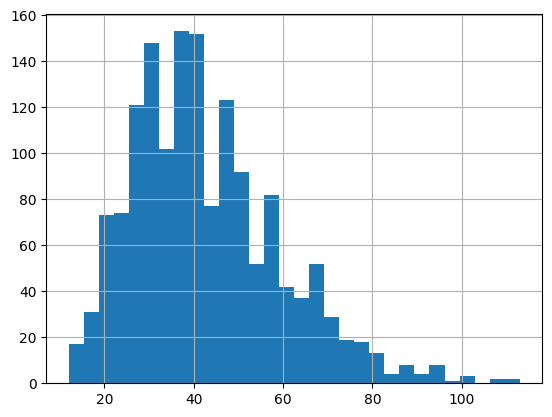

In [106]:
df_clean["airport_travel_time_min"].hist(bins=30)

In [107]:
df_clean["airport_travel_time_min"].describe()

count       1539.0
mean     42.807667
std      16.663133
min           12.0
25%           31.0
50%           40.0
75%           52.0
max          113.0
Name: airport_travel_time_min, dtype: Float64

<Axes: >

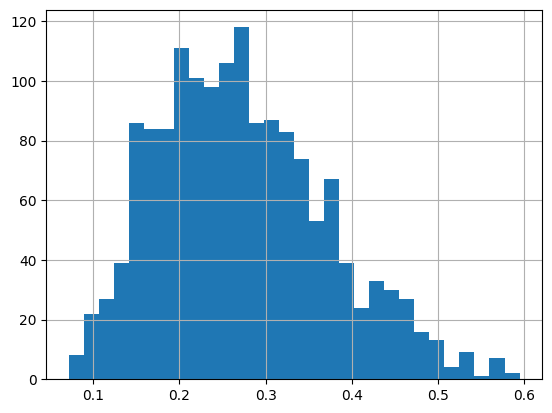

In [108]:
df_clean["access_ratio"] = (
    df_clean["airport_travel_time_min"]
    / df_clean["total_travel_time_min"]
)

df_clean["access_ratio"].hist(bins=30)

In [109]:
df_clean["access_ratio"].describe()

count      1539.0
mean     0.272646
std        0.0986
min      0.071429
25%      0.197452
50%      0.264045
75%      0.335094
max      0.594595
Name: access_ratio, dtype: Float64

<Axes: >

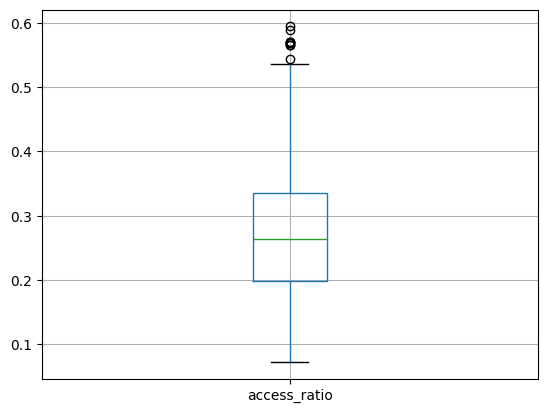

In [110]:
df_clean[["access_ratio"]].boxplot()

In [111]:
all_access = pd.concat([
    df_clean[["origin_iata","origin_travel_time_min"]].rename(columns={"origin_iata":"iata","origin_travel_time_min":"time"}),
    df_clean[["destination_iata","destination_travel_time_min"]].rename(columns={"destination_iata":"iata","destination_travel_time_min":"time"})
])

all_access.groupby("iata")["time"].mean().sort_values(ascending=False).head(20)

iata
PMO    62.0
SZY    60.0
MXP    51.0
STN    48.0
SZZ    46.0
ATH    44.0
PIK    43.0
MUC    40.0
TRD    36.0
TRN    34.0
FCO    32.0
LGW    31.0
CDG    31.0
OSR    31.0
BER    30.0
LYS    27.0
HEL    27.0
TRS    26.0
STR    26.0
GDN    26.0
Name: time, dtype: Float64

In [112]:
df_clean.sort_values("access_ratio", ascending=False).head(20)


,origin_iata,destination_iata,air_travel_time_min,origin_travel_time_min,destination_travel_time_min,airport_travel_time_min,total_travel_time_min,access_ratio
3310,MUC,STR,45,40,26,66,111,0.594595
3422,MUC,STR,46,40,26,66,112,0.589286
2288,FCO,PMO,71,32,62,94,165,0.569697
2287,FCO,PMO,71,32,62,94,165,0.569697
3568,PMO,FCO,71,62,32,94,165,0.569697
3340,MXP,MUC,69,51,40,91,160,0.56875
3283,MUC,MXP,69,40,51,91,160,0.56875
3070,LYS,MXP,60,27,51,78,138,0.565217
3178,LYS,MXP,60,27,51,78,138,0.565217
1241,BRI,PMO,67,18,62,80,147,0.544218


In [120]:
df_clean["airport_travel_time_min"].skew()

np.float64(0.8348888723225518)

## TODO: Analysis by Country

In [121]:
# by iso_country from airports_global dataset